In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [18]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Sp/Imagenes_confocal/sp_para entrenar/'
pathlist = Path(path).glob('*.csv')
sparks_data_list = []
for file in pathlist:
    path_in_str = str(file)
    df = pd.read_csv(path_in_str)
    sparks_data_list.append(df)
sparks_data_list = pd.concat(sparks_data_list)
del (sparks_data_list['Unnamed: 0'])
del (sparks_data_list['minim'])
del (sparks_data_list['FDHM'])
del (sparks_data_list['full_width'])

In [19]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
from lime import lime_tabular

In [20]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

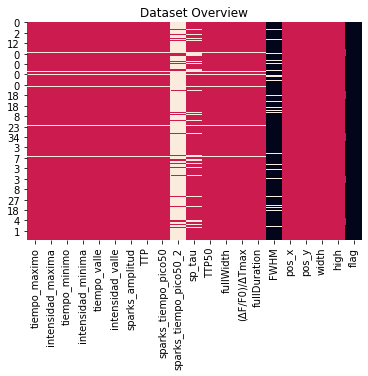

 Categerocial   Numeric   NaN 


In [21]:
dic_cols = {col:utils_recognize_type(sparks_data_list, col, max_cat=20) for col in sparks_data_list.columns}
heatmap = sparks_data_list.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [22]:
dtf = sparks_data_list
dtf = dtf.rename(columns={"flag":"Y"})

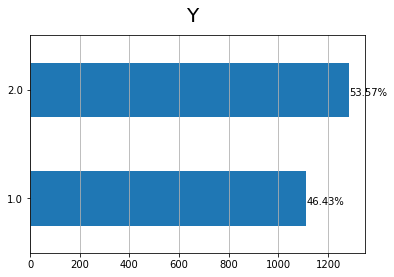

In [23]:
y = "Y"
ax = dtf[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()

/home/leandro/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/leandro/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


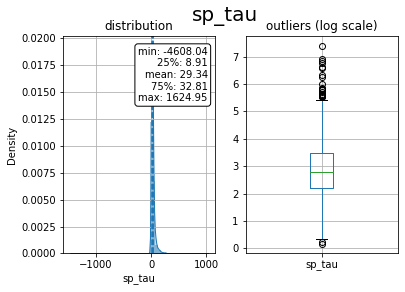

In [24]:
x = "sp_tau"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = dtf[x].fillna(dtf[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = dtf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

/home/leandro/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/leandro/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


KeyError: "None of [Float64Index([2.0, 1.0], dtype='float64', name='Y')] are in the [columns]"

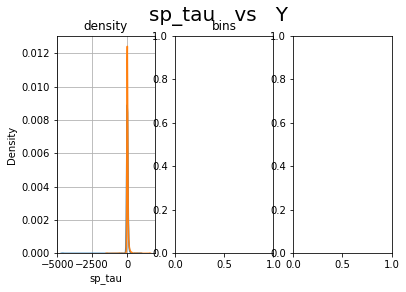

In [25]:
cat, num = "Y", "sp_tau"
fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in dtf[cat].unique():
    sns.distplot(dtf[dtf[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(dtf[num], q=np.linspace(0,1,11))
tmp = dtf.groupby([cat, pd.cut(dtf[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[dtf[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
### boxplot   
ax[2].title.set_text('outliers')
sns.catplot(x=cat, y=num, data=dtf, kind="box", ax=ax[2])
ax[2].grid(True)
plt.show()

In [35]:
cat, num = "Y", "high"
model = smf.ols(num+' ~ '+cat, data=dtf).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Non-Correlated (p-value: 0.229)


In [16]:
sparks_data_list.columns

Index(['tiempo_maximo', 'intensidad_maxima', 'tiempo_minimo',
       'intensidad_minima', 'tiempo_valle', 'intensidad_valle',
       'sparks_amplitud', 'TTP', 'sparks_tiempo_pico50',
       'sparks_tiempo_pico50_2', 'sp_tau', 'TTP50', 'FDHM', 'fullWidth',
       '(ΔF/F0)/ΔTmax', 'fullDuration', 'pos_x', 'pos_y', 'width', 'high',
       'flag'],
      dtype='object')

In [ ]:
x, y = "fullDuration", "Y"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
### count
ax[0].title.set_text('count')
order = dtf.groupby(x)[y].count().index.tolist()
sns.catplot(x=x, hue=y, data=dtf, kind='count', order=order, ax=ax[0])
ax[0].grid(True)
### percentage
ax[1].title.set_text('percentage')
a = dtf.groupby(x)[y].count().reset_index()
a = a.rename(columns={y:"tot"})
b = dtf.groupby([x,y])[y].count()
b = b.rename(columns={y:0}).reset_index()
b = b.merge(a, how="left")
b["%"] = b[0] / b["tot"] *100
sns.barplot(x=x, y="%", hue=y, data=b,
            ax=ax[1]).get_legend().remove()
ax[1].grid(True)
plt.show()

In [ ]:
x, y = "fullDuration", "Y"
cont_table = pd.crosstab(index=dtf[x], columns=dtf[y])
chi2_test = scipy.stats.chi2_contingency(cont_table)
chi2, p = chi2_test[0], chi2_test[1]
n = cont_table.sum().sum()
phi2 = chi2/n
r,k = cont_table.shape
phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
rcorr = r-((r-1)**2)/(n-1)
kcorr = k-((k-1)**2)/(n-1)
coeff = np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))
coeff, p = round(coeff, 3), round(p, 3)
conclusion = "Significant" if p < 0.05 else "Non-Significant"
print("Cramer Correlation:", coeff, conclusion, "(p-value:"+str(p)+")")

In [ ]:
## Create new column
dtf["fullDuration_section"] = dtf["fullDuration"].apply(lambda x: str(x)[0])
## Plot contingency table
cont_table = pd.crosstab(index=dtf["fullDuration_section"], 
             columns=dtf["sparks_amplitud"], values=dtf["Y"], aggfunc="sum")
sns.heatmap(cont_table, annot=True, cmap="YlGnBu", fmt='.0f',
            linewidths=.5).set_title( 
            'Cabin_section vs Pclass (filter: Y)' )

In [ ]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(dtf, 
                      test_size=0.3)
## print info
print("X_train shape:", dtf_train.drop("Y",axis=1).shape, "| X_test shape:", dtf_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["Y"]),2), "| y_test mean:", round(np.mean(dtf_test["Y"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("Y",axis=1).columns.to_list())

In [ ]:
dtf_train["fullDuration"] = dtf_train["fullDuration"].fillna(dtf_train["fullDuration"].mean())

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dtf_train.drop("Y", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("Y", axis=1).columns, index=dtf_train.index)
dtf_scaled["Y"] = dtf_train["Y"]
dtf_scaled.head()

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import cv2
import random
import numpy as np
from PIL import Image